# Examining the Speedup of Using SparseTensor in PyTorch Geometric

This notebook is based on the code at https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html

## Importing packages

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pytorch_memlab

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
import torch_geometric.transforms as T
from torch_geometric.datasets import *
from torch_geometric.profile import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

     |████████████████████████████████| 7.9 MB 12.2 MB/s 
     |████████████████████████████████| 3.5 MB 12.7 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
  Created wheel for pytorch-memlab: filename=pytorch_memlab-0.2.4-py3-none-any.whl size=22855 sha256=61704369f670aaf379cd8c43d6a5f0e9349ab3666ee1216d39b186f4389eb28f
  Stored in directory: /root/.cache/pip/wheels/bb/c4/8e/64b321e10754783fb334f883d21b651860ee0737ffdbf688c7
  Created wheel for calmsize: filename=calmsize-0.1.3-py3-none-any.whl size=2887 sha256=333beb710520aa78c87689330abc375b4ad27dbf4787819bad6eaa431bc47f91
  Stored in directory: /root/.cache/pip/wheels/a3/92/5f/c4c4e3fa257084aecbdc44c0fe60bdef0cb870603f3642dd96
Successfully built pytorch-memlab calmsize


## Extracting GPU information

In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-31900078-538b-9f50-c45a-01c14b7e9200)


In [3]:
!nvidia-smi

Mon Mar 14 21:09:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


## Setting up functions regarding dataset and model statistics 

In [4]:
def get_dataset_stats(dataset):
  data = dataset[0]  # Get the first graph object.

  print("Dataset STATS", data)
  print('==============================================================')

  # Gather some statistics about the graph.
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

get_dataset_stats(Planetoid("Planetoid", name="Cora"))

Dataset STATS Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


In [5]:
get_dataset_stats(Planetoid("Planetoid", name="Cora", transform=T.ToSparseTensor()))

Dataset STATS Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], adj_t=[2708, 2708, nnz=10556])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
def get_info(model, data):
  # https://pytorch-geometric.readthedocs.io/en/latest/modules/profile.html?highlight=profileit#torch_geometric.profile.get_cpu_memory_from_gc
  print("MODEL INFO", model, data)
  print("trainable parameters count", count_parameters(model))
  print("model size in bytes", get_model_size(model))
  print("Data theoretical memory usage in bytes", get_data_size(data))
  print("CPU memory", get_cpu_memory_from_gc())
  print("GPU memory", get_gpu_memory_from_gc(0))
  print("nvidia-smi free and used GPU memory", get_gpu_memory_from_nvidia_smi())

## Setting up the original model (without SparseTensor)

In [7]:
def run_original(dataset):
  class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, cached=True)
        self.conv2 = GCNConv(16, dataset.num_classes, cached=True)

    def forward(self, x, adj_t):
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = self.conv2(x, adj_t)
        return F.log_softmax(x, dim=1)

  #dataset = Planetoid("Planetoid", name="Cora")#, transform=T.ToSparseTensor())
  data = dataset[0]

  model = GNN()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  print("RUNNING ORIGINAL")
  #get_dataset_stats(dataset)
  get_info(model, data)

  @profileit()
  def train(model, data):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)#adj_t)
      loss = F.nll_loss(out, data.y)
      loss.backward()
      optimizer.step()
      return float(loss)

  all_stats = []
  for epoch in range(1, 201):
      loss, stats = train(model, data)
      #print(stats)
      all_stats.append(stats)
  return all_stats

## Using SparseTensor

In [8]:
def run_sparsetensor(dataset2):
  class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset2.num_features, 16, cached=True)
        self.conv2 = GCNConv(16, dataset2.num_classes, cached=True)

    def forward(self, x, adj_t):
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = self.conv2(x, adj_t)
        return F.log_softmax(x, dim=1)

  #dataset2 = Planetoid("Planetoid", name="Cora", transform=T.ToSparseTensor())
  data2 = dataset2[0]

  model2 = GNN()
  optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

  print("RUNNING SPARSETENSOR")
  #get_dataset_stats(dataset2)
  get_info(model2, data2)

  @profileit()
  def train(model, data):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.adj_t)
      loss = F.nll_loss(out, data.y)
      loss.backward()
      optimizer.step()
      return float(loss)

  all_stats = []
  for epoch in range(1, 201):
      loss, stats = train(model2, data2)
      #print(stats)
      all_stats.append(stats)
  return (all_stats)

In [9]:
def run_all(name, dataset1, dataset2):

  print("DATASET STATS OF ORIGINAL")
  get_dataset_stats(dataset1)
  print()
  print("DATASET STATS OF SPARSETENSOR")
  get_dataset_stats(dataset2)

  all_stats1 = run_original(dataset1)
  stats1_sum = get_stats_summary(all_stats1)
  print("STATS_SUM1", stats1_sum)
  times1 = [all_stats1[i].time for i in range(len(all_stats1))]

  all_stats2 = run_sparsetensor(dataset2)
  stats2_sum = get_stats_summary(all_stats2)
  print("STATS_SUM2", stats2_sum)
  times2 = [all_stats2[i].time for i in range(len(all_stats2))]
  print("SPEEDUP of", stats1_sum.time_mean/stats2_sum.time_mean)
  plt.title(name)
  plt.plot(range(1, len(times1)), times1[1:])
  plt.plot(range(1, len(times2)), times2[1:])
  plt.axhline(y=stats1_sum.time_mean, color='g', linestyle='-')
  plt.axhline(y=stats2_sum.time_mean, color='r', linestyle='-')
  plt.legend(["Original", "with SparseTensor"])
  plt.xlabel("Training iteration")
  plt.ylabel("Time (s)")
  plt.savefig(f'{name}.png', bbox_inches='tight')
  plt.plot()

## Running the full experiments

DATASET STATS OF ORIGINAL
Dataset STATS Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True

DATASET STATS OF SPARSETENSOR
Dataset STATS Data(x=[34, 34], y=[34], train_mask=[34], adj_t=[34, 34, nnz=156])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True
RUNNING ORIGINAL
MODEL INFO GNN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
) Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
trainable parameters count 628
model size in bytes 4063
Data theoretical memory usage in bytes 7426
CPU memory 17440
GPU memory 0
nvidia-smi free and used GPU memory (11992.74, 3.15)


/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "

PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.7/dist-packages/pytorch_memlab/line_profiler/line_profiler.py", line 81, in register_callback
    sys.settrace(self._trace_callback)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to

STATS_SUM1 StatsSummary(time_mean=0.006667777430266142, time_std=0.004790047183632851, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
RUNNING SPARSETENSOR
MODEL INFO GNN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
) Data(x=[34, 34], y=[34], train_mask=[34], adj_t=[34, 34, nnz=156])
trainable parameters count 628
model size in bytes 4063
Data theoretical memory usage in bytes 6458
CPU memory 41608
GPU memory 0


/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM2 StatsSummary(time_mean=0.005908755119889975, time_std=0.002533168299123645, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
SPEEDUP of 1.1284572291414068


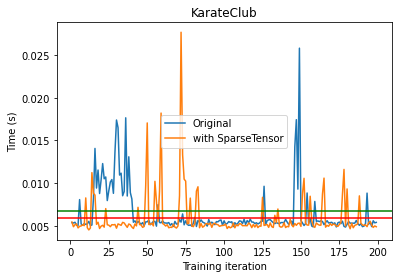

In [10]:
run_all("KarateClub", KarateClub(), KarateClub(transform=T.ToSparseTensor()))

DATASET STATS OF ORIGINAL
Dataset STATS Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True

DATASET STATS OF SPARSETENSOR
Dataset STATS Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], adj_t=[2708, 2708, nnz=10556])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
RUNNING ORIGINAL
MODEL INFO GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
) Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
trainable parameters count 23063
model size in bytes 93791
Data theoretical memory usage in b

/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM1 StatsSummary(time_mean=0.020521488040685654, time_std=0.004157674964517355, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
RUNNING SPARSETENSOR
MODEL INFO GNN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
) Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], adj_t=[2708, 2708, nnz=10556])
trainable parameters count 23063
model size in bytes 93791
Data theoretical memory usage in bytes 15658164
CPU memory 32921948
GPU memory 0


/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM2 StatsSummary(time_mean=0.014864559285342693, time_std=0.004878064151853323, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
SPEEDUP of 1.3805648486949098


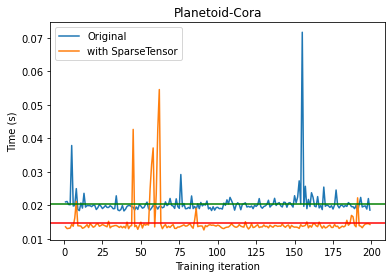

In [11]:
run_all("Planetoid-Cora", Planetoid("Planetoid", name="Cora"), Planetoid("Planetoid", name="Cora", transform=T.ToSparseTensor()))

Processing...
Done!


DATASET STATS OF ORIGINAL
Dataset STATS Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True

DATASET STATS OF SPARSETENSOR
Dataset STATS Data(x=[3327, 3703], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], adj_t=[3327, 3327, nnz=9104])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True
RUNNING ORIGINAL
MODEL INFO GNN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
) Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
trainable parameters count 59366
model size in bytes 239007
Data theoretical memory usage in bytes 4

/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM1 StatsSummary(time_mean=0.03691159188747406, time_std=0.003045860445126891, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
RUNNING SPARSETENSOR
MODEL INFO GNN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
) Data(x=[3327, 3703], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], adj_t=[3327, 3327, nnz=9104])
trainable parameters count 59366
model size in bytes 239007
Data theoretical memory usage in bytes 49415577
CPU memory 2952972346
GPU memory 0


/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM2 StatsSummary(time_mean=0.0321902334690094, time_std=0.007021497935056686, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
SPEEDUP of 1.1466705242448791


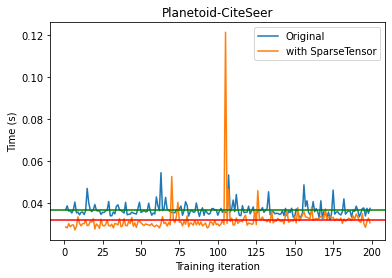

In [20]:
run_all("Planetoid-CiteSeer", Planetoid("Planetoid", name="CiteSeer"), Planetoid("Planetoid", name="CiteSeer", transform=T.ToSparseTensor()))

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


DATASET STATS OF ORIGINAL
Dataset STATS Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True

DATASET STATS OF SPARSETENSOR
Dataset STATS Data(x=[19717, 500], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717], adj_t=[19717, 19717, nnz=88648])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
RUNNING ORIGINAL
MODEL INFO GNN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
) Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
trainable parameters count 8067
model size in bytes 33823
Data theoretical memor

/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:171: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


nvidia-smi free and used GPU memory (11451.72, 544.17)
STATS_SUM2 StatsSummary(time_mean=0.04571344330906868, time_std=0.006037483923137188, max_allocated_cuda=0.0, max_reserved_cuda=0.0, max_active_cuda=0.0, min_nvidia_smi_free_cuda=11451.72, max_nvidia_smi_used_cuda=544.17)
SPEEDUP of 1.8810159701132148


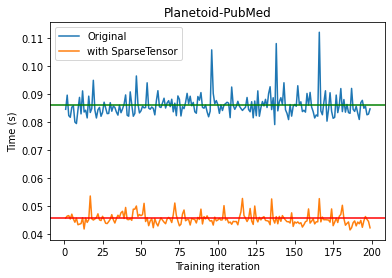

In [21]:
run_all("Planetoid-PubMed", Planetoid("Planetoid", name="PubMed"), Planetoid("Planetoid", name="PubMed", transform=T.ToSparseTensor()))